<a href="https://colab.research.google.com/github/charlie9526/TaxiFare/blob/master/visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) IMPORTS

In [1]:
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks/FAIR_TAXI

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/FAIR_TAXI


In [3]:
!pip install pandas
!pip install matplotlib
!pip install sklearn

In [4]:
import pandas as pd
import random
import math
# from google.colab import files
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)              
import numpy as np                  
from scipy.stats import norm   
import warnings
warnings.filterwarnings('ignore')   
%matplotlib inline                 

from sklearn.base import BaseEstimator, TransformerMixin
from math import sin, cos, sqrt, atan2, radians
from datetime import datetime


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 2) Functions

In [6]:
##################### extract distance from longitude and lattitudes
##################### lambda function
def get_distance(x):
  R = 6373.0
  lat1 = radians(float(x['drop_lat']))
  lon1 = radians(float(x['drop_lon']))
  lat2 = radians(float(x['pick_lat']))
  lon2 = radians(float(x['pick_lon']))

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  distance = R * c
  return distance
  
################### Lets get date out as a column
################### lambda function

def get_date_value(x,date_time_column_name):
  if x[date_time_column_name]==None:
    return None
  return datetime.strptime(x[date_time_column_name],"%m/%d/%Y %H:%M").day

def get_month_value(x,date_time_column_name):
  if x[date_time_column_name]==None:
    return None
  return datetime.strptime(x[date_time_column_name],"%m/%d/%Y %H:%M").month 

################### Here we have to add two columns
################### The hour value and fare per hour value
################### Lets write a lambda function 

def get_hour_value(x,date_time_column_name):
  if x[date_time_column_name]==None:
    return None
  return datetime.strptime(x[date_time_column_name],"%m/%d/%Y %H:%M").hour

################### Here we have to add fare_per_hour column
################### write a lambda function

def get_fare_per_min(x):
  if x["fare"]>=0 and x["duration"]>0:
    minutes = x["duration"]/60.0
    val = x['fare']/minutes
    return val
  if x["duration"]==0:
    return 0
  return None
########### This is a very specific function
########### Find the difference of durations
def get_duration_gap(x):
  if x['duration']=="NaN"or x['duration_by_me']=="NaN":
    return x['duration_by_me']
  return abs(x['duration']-x['duration_by_me'])
########### This is for getting fare per distance 
########### Lambda function
def get_fare_per_distance(x):
  if x['distance']==0:
    return 0
  if x['meter_waiting_fare']>0:
    return float(x['fare']-x['meter_waiting_fare'])/x['distance']
  else:
    return float(x['fare'])/x['distance']

########### This function is a transformer
########### Converts all null values of duration using drop time and pick time

#elts write a lambda function
def get_duration(x):
  if x['pickup_time']==None or x['drop_time']==None:
    return None
  
  try :
    if int(x['pickup_time'].split("/")[1])>12 or int(x['drop_time'].split("/")[1])>12:
      gap = datetime.strptime(x['pickup_time'],"%m/%d/%Y %H:%M")-datetime.strptime(x['drop_time'],"%m/%d/%Y %H:%M")
    else:
      if int(x['pickup_time'].split("/")[1]) != int(x['drop_time'].split("/")[1]):
        gap = datetime.strptime(x['pickup_time'],"%m/%d/%Y %H:%M")-datetime.strptime(x['drop_time'],"%m/%d/%Y %H:%M")
      else:
        gap = datetime.strptime(x['pickup_time'],"%d/%m/%Y %H:%M")-datetime.strptime(x['drop_time'],"%d/%m/%Y %H:%M")
    # print (gap.total_seconds()/3600,x['pickup_time'] ,x['drop_time'])
  except :
    # print(int(x['pickup_time'].split("/")[0])>12 or int(x['drop_time'].split("/")[0])>12)
    return None
  # print(abs(gap.total_seconds()/3600), x['drop_time'],x['pickup_time'])
  disti =  abs(gap.total_seconds())
  return disti

class MakeTripDurationFeature(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['duration_by_me'] = X.apply(lambda x:get_duration(x), axis=1)
        return X
# datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')
def get_time_type(df):
  pickup_slot=[]
  both="Both"
  school="School"
  office="Office"
  free="free"
  midnight = "midnight"
  for index, row in df.iterrows():
    pickup_datetime=row['pickup_time']
    midnight_start = "22:00"
    midnight_end = "2:30" 
    both_start="7:00"
    both_end="9:00"
    school_start="13:00"
    school_end="15:00"
    office_start="16:00"
    office_end="20:00"

    pickup_time=datetime.strptime(pickup_datetime.split(" ")[1],'%H:%M')
    midnight_start_time = datetime.strptime(midnight_start,'%H:%M')
    midnight_end_time = datetime.strptime(midnight_end,'%H:%M')
    both_start_time=datetime.strptime(both_start,'%H:%M')
    both_end_time=datetime.strptime(both_end,'%H:%M')
    school_start_time=datetime.strptime(school_start,'%H:%M')
    school_end_time=datetime.strptime(school_end,'%H:%M')
    office_start_time=datetime.strptime(office_start,'%H:%M')
    office_end_time=datetime.strptime(office_end,'%H:%M')
    
    if(pickup_time> both_start_time and pickup_time<both_end_time):
      pickup_slot.append(both)
      # print(pickup_time,both)
    elif(pickup_time> midnight_start_time or pickup_time<midnight_end_time):
      pickup_slot.append(midnight)
    elif(pickup_time> school_start_time and pickup_time<school_end_time):
      pickup_slot.append(school)
      # print(pickup_time,school)
    elif(pickup_time>office_start_time and pickup_time<office_end_time):
      pickup_slot.append(office)
      # print(pickup_time,office)
    else:
      pickup_slot.append(free)
      # print(pickup_time,free)
    

    
  return pickup_slot

def get_waiting_rate(x):
  if math.isnan(x['meter_waiting']):
    return float('nan')
  if x['meter_waiting']==0:
    return 0
  if  x['meter_waiting_fare']>=0:
    return (float(x['meter_waiting_fare'])/x['meter_waiting'])
  else:
    return float('nan')


#################distance per min
def get_velocity(x):
  if math.isnan(x['duration']) or math.isnan(x['distance']):
    return 0
  if x['duration']==0:
    return 0
  return (float(x['distance'])/x['duration'])*3600

################### Fill null durations
def fill_duration_nans(x):
  if math.isnan(x['duration']):
    return get_duration(x)
  return x['duration']

#3) PRE PROCESS

## 3.1) add new features


In [ ]:
## FILL NULL VALUSE OF DURATION 
add_duration_by_me = MakeTripDurationFeature()
train_df = add_duration_by_me.transform(train_df)
train_df['duration_gap'] = train_df.apply(lambda x:get_duration_gap(x), axis=1)

train_df['distance'] = train_df.apply(lambda x:get_distance(x), axis=1)

train_df['pickup_hour'] = train_df.apply(lambda x:get_hour_value(x,"pickup_time"),axis=1)
train_df['drop_hour'] = train_df.apply(lambda x:get_hour_value(x,"drop_time"),axis=1)
train_df['fare_per_min'] = train_df.apply(lambda x:get_fare_per_min(x),axis=1 )

train_df['month'] = train_df.apply(lambda x:get_month_value(x,"drop_time"),axis=1)
train_df['date'] = train_df.apply(lambda x:get_date_value(x,"drop_time"),axis=1)

train_df['fare_per_distance'] = train_df.apply(lambda x:get_fare_per_distance(x),axis=1)
train_df['velocity'] = train_df.apply(lambda x:get_velocity(x), axis=1)

train_df['pure_fare'] = train_df['fare']-train_df['additional_fare']-train_df['meter_waiting_fare']

## 3.2) compare duration column of dataset with actual duration exrtracted from pick and drop time. duration gap is the difference of both


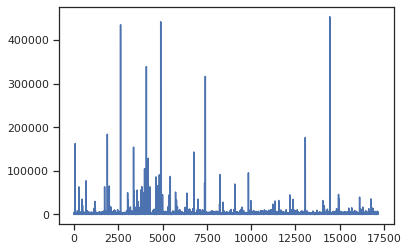

In [ ]:
plt.plot(train_df['duration_gap'])
# plt.ylim(0,)
# plt.grid(True)
plt.show()

In [ ]:
# lets check difference values more than 50
train_df[abs(train_df['duration_gap'])>60].head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,duration_by_me,duration_gap,distance,pickup_hour,drop_hour,fare_per_min,month,date,fare_per_distance,velocity,pure_fare
20,189157607,10.5,2956.0,1686.0,97.4508,29.0,11/1/2019 8:40,11/1/2019 9:21,6.92109,79.8547,6.94120,79.8588,NaN,incorrect,2460.0,496.0,2.282184,8,9,NaN,11,1,NaN,2.779385,NaN
22,189157559,10.5,693.0,280.0,9.8838,318.0,11/1/2019 8:41,11/1/2019 8:51,6.91718,79.8656,6.90640,79.8793,109.36,correct,600.0,93.0,1.930343,8,8,9.468398,11,1,51.532906,10.027757,88.9762
27,189163162,10.5,618.0,128.0,7.3984,126.0,11/1/2019 9:12,11/1/2019 9:20,6.88661,79.9321,6.87383,79.9263,106.80,correct,480.0,138.0,1.559146,9,9,10.368932,11,1,63.753888,9.082402,88.9016
30,189164806,10.5,3549.0,2689.0,146.9854,69.0,11/1/2019 9:16,11/1/2019 9:29,6.91657,79.8593,6.89258,79.8554,NaN,incorrect,780.0,2769.0,2.702931,9,9,NaN,11,1,NaN,2.741773,NaN
1924,191263471,5.0,39.0,19.0,1.1077,0.0,11/11/2019 11:00,11/11/2019 11:09,6.93940,79.8756,6.93693,79.8641,NaN,incorrect,540.0,501.0,1.299158,11,11,NaN,11,11,NaN,119.922294,NaN


In [ ]:
# 
train_df[train_df['duration'].isnull()].head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,duration_by_me,duration_gap,distance,pickup_hour,drop_hour,fare_per_min,month,date,fare_per_distance,velocity,pure_fare
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct,1020.0,NaN,8.150340,3,3,NaN,11,1,43.972399,0.0,NaN
31,189164831,NaN,NaN,NaN,NaN,NaN,11/1/2019 9:17,11/1/2019 9:25,7.27586,80.6136,7.28810,80.6319,NaN,incorrect,480.0,NaN,2.435215,9,9,NaN,11,1,NaN,0.0,NaN
91,189231599,NaN,NaN,NaN,NaN,NaN,11/1/2019 14:48,11/1/2019 15:03,7.04783,79.8973,7.05307,79.9188,196.50,incorrect,900.0,NaN,2.443878,14,15,NaN,11,1,80.405009,0.0,NaN
253,189393356,NaN,NaN,NaN,NaN,NaN,11/2/2019 13:29,11/2/2019 13:55,7.21158,79.8401,7.20136,79.8455,188.71,incorrect,1560.0,NaN,1.283486,13,13,NaN,11,2,147.029277,0.0,NaN
811,190066074,NaN,NaN,NaN,NaN,NaN,11/5/2019 16:49,11/5/2019 17:01,7.48201,80.3580,7.50463,80.3510,NaN,incorrect,720.0,NaN,2.631781,16,17,NaN,11,5,NaN,0.0,NaN


## 3.3) Check fare with the day's time period

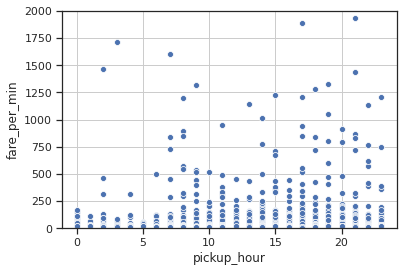

In [ ]:
graph = sns.scatterplot(x="pickup_hour",y="fare_per_min",data=train_df)
graph.set_ylim(0,2000)
graph.grid(True)

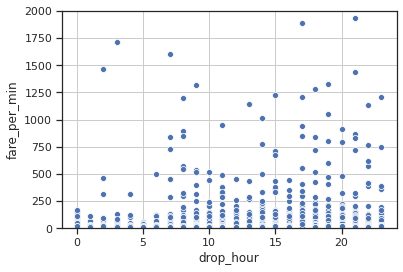

In [ ]:
graph = sns.scatterplot(x="drop_hour",y="fare_per_min",data=train_df)
graph.set_ylim(0,2000)
graph.grid(True)

In [ ]:
train_df.isna().sum()

tripid                         0
additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         137
label                          0
duration_by_me                 0
duration_gap                 202
distance                       0
pickup_hour                    0
drop_hour                      0
fare_per_min                 208
month                          0
date                           0
fare_per_distance            137
velocity                       0
pure_fare                    208
dtype: int64

**Decesion**


---
Here the duration gap of null duration values are not considered. They are irrelevant here.\
Only two observations form the whole datasset are passed the duration gap around 100.\
those id s are \
     1) 213112837	\
     2) 193653017	


## 3.4) Correlation matrix

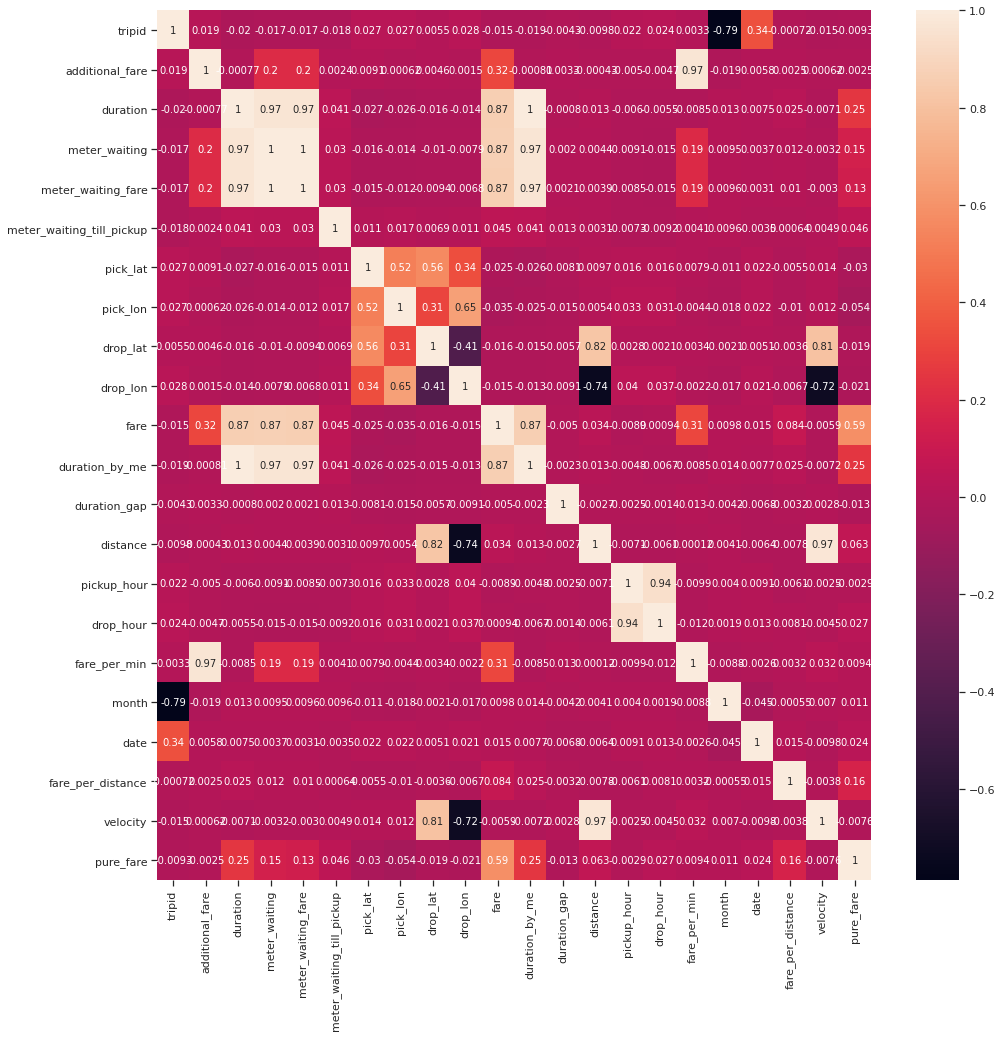

In [ ]:


corrMatrix = train_df.corr()
plt.figure(figsize = (16,16))
sns.heatmap(corrMatrix, annot=True)
plt.show()

## 3.5) distance  fare

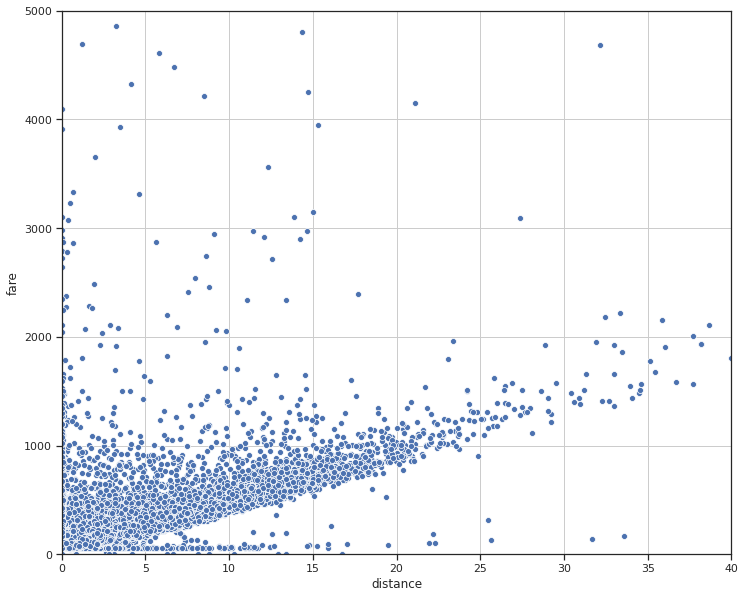

In [ ]:
plt.figure(figsize = (12,10))

graph = sns.scatterplot(x="distance",y="fare",data=train_df)
graph.set_ylim(0,5000)
graph.set_xlim(0,40)
graph.grid(True)

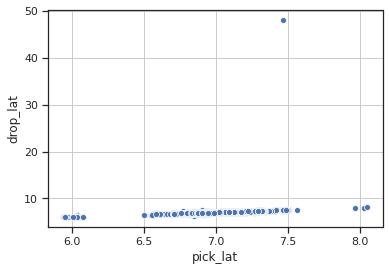

In [ ]:
graph = sns.scatterplot(x="pick_lat",y="drop_lat",data=train_df)
# graph.set_ylim(0,2000)
# graph.set_xlim(0,100)
graph.grid(True)

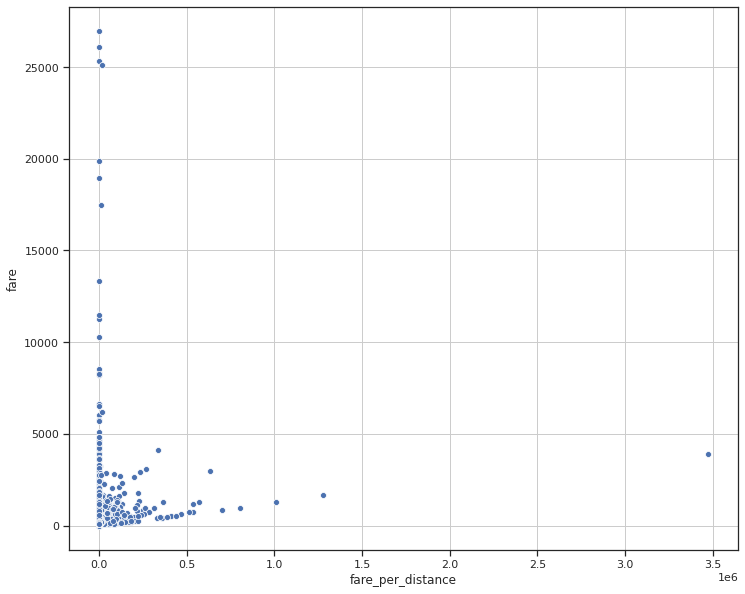

In [ ]:
plt.figure(figsize = (12,10))

graph = sns.scatterplot(x="fare_per_distance",y="fare",data=train_df)
# graph.set_ylim(0,5000)
# graph.set_xlim(0,40)
graph.grid(True)

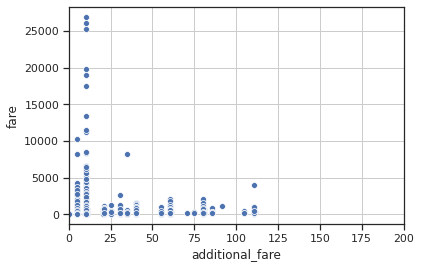

In [ ]:
graph = sns.scatterplot(x="additional_fare",y="fare",data=train_df)
# graph.set_ylim(0,5000)
graph.set_xlim(0,200)
graph.grid(True)

## 3.6) fare per min vs date

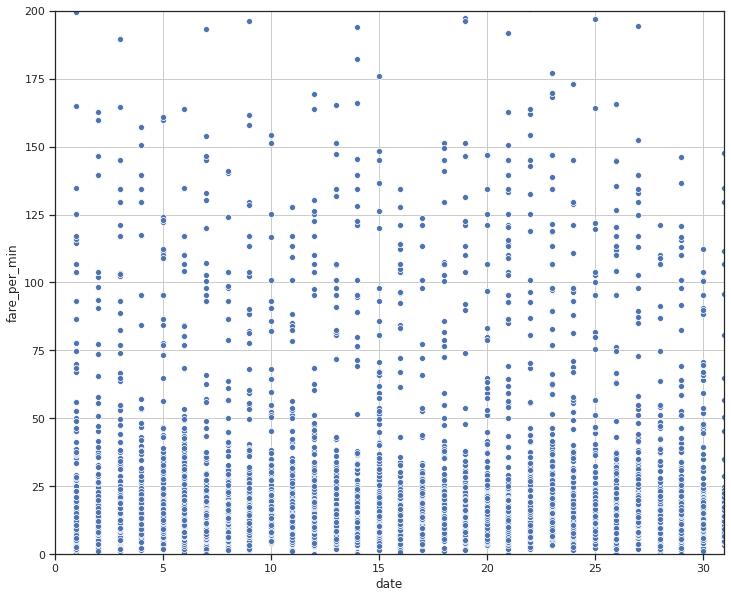

In [ ]:

plt.figure(figsize = (12,10))
graph = sns.scatterplot(x="date",y="fare_per_min",data=train_df)
graph.set_ylim(0,200)
graph.set_xlim(0,31)
graph.grid(True)

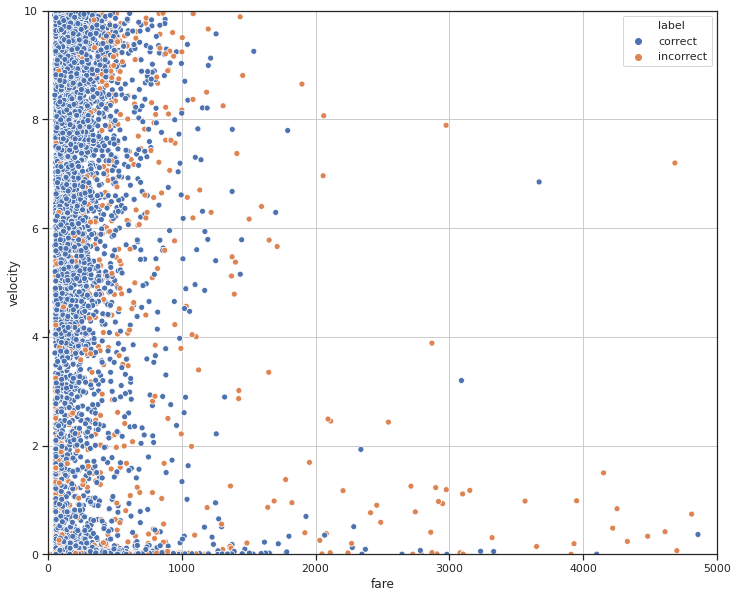

In [ ]:

plt.figure(figsize = (12,10))
graph = sns.scatterplot(x="fare",y="velocity",data=train_df ,hue='label')
graph.set_ylim(0,10)
graph.set_xlim(0,5000)
graph.grid(True)

# 4) Dcesions

**1) Evaluate default "duration" and real duration.**


---
Here the duration gap of null duration values are not considered. They are irrelevant here.\
Only two observations form the whole datasset are passed the duration gap around 100.\
those id s are \
     1) 213112837	\
     2) 193653017	\
this was tried. but not successfull effect


**2) Remove Null fare values as whole row**

---
No point of fare null values because the fare should be the most important


**3) Fill Null duration values with real duration**

**4) Its better to use pickup hour and drop hour**

---
There is a small releationship can be seen in 3.3 section 


**5) Correlations**

---
  i)   Meter waiting time vs Meter waiting fare => 1 \
  ii)  Meter waiting vs Duration => .97 \
  iii) Pickup hour vs Drop hour => .94 \


**6) Fare per min and fare per**

---
"fare_per_mi", "fare_per_dis" has a relationship with fare directly.


**7) hour**

---
"pick hour" "drop hour" are not much valuable


# 5) Devide geo locations into main three areas. Those are Colombo, Kandy and Galle areas.


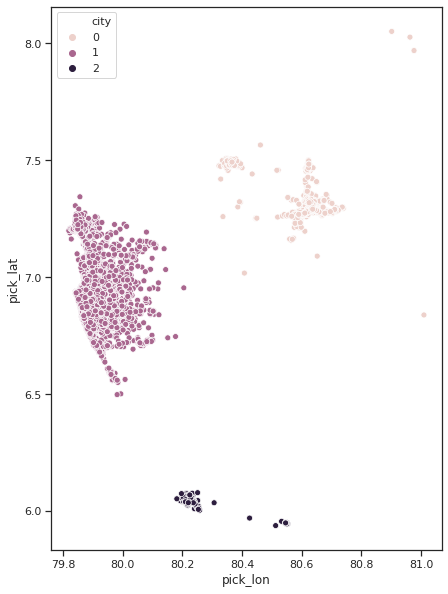

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
plt.figure(figsize = (7,10))
# print ( train_df.count())
# print ( train_df.count())
train_df['meter_waiting'].fillna(0,inplace=True)
train_df['duration'].fillna(0,inplace=True)
train_df['additional_fare'].fillna(10.5,inplace=True)

train_df = train_df[train_df['drop_lon']>75]
train_df['city'] = kmeans.fit(train_df[['pick_lon','pick_lat']]).predict(train_df[['pick_lon','pick_lat']])
graph = sns.scatterplot(x=train_df['pick_lon'], y=train_df['pick_lat'], hue=train_df['city']);


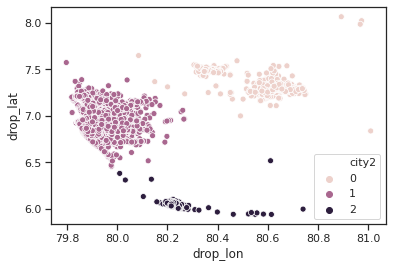

In [ ]:

train_df = train_df[train_df['drop_lon']>75]
train_df['city2'] = kmeans.fit(train_df[['drop_lon','drop_lat']]).predict(train_df[['drop_lon','drop_lat']])
graph = sns.scatterplot(x=train_df['drop_lon'], y=train_df['drop_lat'], hue=train_df['city2']);

In [ ]:
train_df[train_df['city']!=train_df['city2']]


,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,duration_by_me,duration_gap,distance,pickup_hour,drop_hour,fare_per_min,month,date,fare_per_distance,velocity,pure_fare,city,city2
3680,193841338,10.5,16086.0,2832.0,163.6896,973.0,11/22/2019 12:10,11/22/2019 16:38,6.95433,80.2046,7.23645,80.2686,4683.27,incorrect,16080.0,6.0,32.165466,12,16,17.468370,11,22,140.510335,7.198538,4509.0804,1,0
3859,194256573,5.0,21286.0,13414.0,782.0362,0.0,11/23/2019 7:43,11/23/2019 13:38,7.10141,79.8991,7.36790,80.1492,3669.43,correct,21300.0,14.0,40.499700,7,13,10.343221,11,23,71.294202,6.849522,2882.3938,1,0
9896,203475249,10.5,9271.0,790.0,45.6620,115.0,12/23/2019 18:33,12/23/2019 21:08,6.84642,79.9487,7.31178,80.2002,2841.27,correct,9300.0,29.0,58.736424,18,21,18.388113,12,23,47.595815,22.807801,2785.1080,1,0
13055,208649108,10.5,176620.0,176164.0,10173.3780,10.0,1/10/2020 14:34,1/12/2020 15:38,6.84841,79.9252,6.32008,80.1358,13350.32,incorrect,176640.0,20.0,63.205709,14,15,4.535269,1,12,50.263529,1.288306,3166.4420,1,2
14045,209981901,10.5,31921.0,8364.0,483.4392,38.0,1/16/2020 6:27,1/16/2020 15:19,6.82345,79.9625,6.51834,80.6107,6524.06,incorrect,31920.0,1.0,79.245643,6,15,12.262887,1,16,76.226535,8.937199,6030.1208,1,2


In [ ]:
train_df['delta_duration']=(train_df['duration']-train_df['meter_waiting'])/60
train_df[~((train_df['duration']<15000)| (train_df['label']=='incorrect'))]


,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,duration_by_me,duration_gap,distance,pickup_hour,drop_hour,fare_per_min,month,date,fare_per_distance,velocity,pure_fare,city,city2,delta_duration
74,189213407,5.0,162747.0,162277.0,9460.749100,0.0,11/1/2019 13:35,11/3/2019 10:48,6.78440,79.8845,6.89959,79.8646,10264.42,correct,162780.0,33.0,12.999682,13,10,3.784188,11,3,61.822350,0.287556,798.670900,1,1,7.833333
486,189800308,10.5,20699.0,12954.0,755.218200,3.0,11/4/2019 8:29,11/4/2019 14:14,7.00309,79.9120,6.91717,79.8609,2338.56,correct,20700.0,1.0,11.097991,8,14,6.778762,11,4,142.669228,1.930179,1572.841800,1,1,129.083333
1194,190392777,5.0,29769.0,18170.0,1059.311000,0.0,11/7/2019 13:14,11/7/2019 21:30,6.94815,79.8572,6.95080,79.8605,3232.27,correct,29760.0,9.0,0.468660,13,21,6.514703,11,7,4636.534007,0.056676,2167.959000,1,1,193.316667
2086,191409182,10.5,17034.0,5590.0,323.102000,34.0,11/12/2019 9:51,11/12/2019 14:35,6.80098,79.9402,6.80096,79.9401,4099.55,correct,17040.0,6.0,0.011267,9,14,14.440120,11,12,335191.897669,0.002381,3765.948000,1,1,190.733333
3461,193585269,10.5,16663.0,8400.0,485.520000,49.0,11/21/2019 9:47,11/21/2019 14:24,6.91258,79.8744,6.91254,79.8746,1533.96,correct,16620.0,43.0,0.022528,9,14,5.523471,11,21,46539.459275,0.004867,1037.940000,1,1,137.716667
3859,194256573,5.0,21286.0,13414.0,782.036200,0.0,11/23/2019 7:43,11/23/2019 13:38,7.10141,79.8991,7.36790,80.1492,3669.43,correct,21300.0,14.0,40.499700,7,13,10.343221,11,23,71.294202,6.849522,2882.393800,1,0,131.200000
5298,196590684,10.5,16429.0,321.0,18.553800,16.0,11/30/2019 12:47,11/30/2019 17:20,6.85502,79.8993,6.84307,79.9628,681.62,correct,16380.0,49.0,7.137548,12,17,2.489330,11,30,92.898315,1.564013,652.566200,1,1,268.466667
6275,197984654,5.0,16272.0,6956.0,405.534800,0.0,12/5/2019 12:20,12/5/2019 16:52,6.80771,79.8967,6.80761,79.8967,2645.81,correct,16320.0,48.0,0.011123,12,16,9.755937,12,5,201409.562071,0.002461,2235.275200,1,1,155.266667
6371,198205664,5.0,49000.0,46756.0,2725.874800,0.0,12/5/2019 18:49,12/6/2019 8:26,6.83299,79.9793,6.83906,79.9780,3330.11,correct,49020.0,20.0,0.690261,18,8,4.077686,12,6,875.371862,0.050713,599.235200,1,1,37.400000
9846,203358177,35.0,95432.0,81081.0,4727.022300,0.0,12/23/2019 14:30,12/24/2019 17:01,6.84191,79.8673,6.89527,79.8579,8270.70,correct,95460.0,28.0,6.025317,14,17,5.199954,12,24,588.131338,0.227294,3508.677700,1,1,239.183333


In [ ]:
train_df[train_df['meter_waiting_till_pickup']>600]


,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,duration_by_me,duration_gap,distance,pickup_hour,drop_hour,fare_per_min,month,date,fare_per_distance,velocity,pure_fare,city,city2,delta_duration
124,189258007,10.5,1567.0,383.0,22.1374,1104.0,11/1/2019 17:18,11/1/2019 17:44,6.72069,79.9062,6.79549,79.8813,378.93,correct,1560.0,7.0,8.762810,17,17,14.509126,11,1,40.716687,20.131536,346.2926,1,1,19.733333
255,189394373,10.5,2786.0,697.0,40.2866,612.0,11/2/2019 13:38,11/2/2019 14:24,6.93452,79.8523,6.87663,79.9162,504.00,correct,2760.0,26.0,9.552457,13,14,10.854271,11,2,48.543888,12.343448,453.2134,1,1,34.816667
299,189433901,10.5,1097.0,0.0,0.0000,768.0,11/2/2019 17:23,11/2/2019 17:41,6.81348,79.9768,6.81074,79.9848,60.50,incorrect,1080.0,17.0,0.934643,17,17,3.309025,11,2,64.730609,3.067196,50.0000,1,1,18.283333
448,189737409,10.5,507.0,40.0,2.3120,733.0,11/3/2019 19:48,11/3/2019 19:56,7.09257,79.9918,7.09753,79.9736,144.85,correct,480.0,27.0,2.083261,19,19,17.142012,11,3,68.420606,14.792388,132.0380,1,1,7.783333
489,189801272,10.5,524.0,163.0,8.7856,661.0,11/4/2019 8:51,11/4/2019 9:00,7.47346,80.6249,7.45146,80.6309,133.60,correct,540.0,16.0,2.534949,8,9,15.297710,11,4,49.237440,17.415680,114.3144,0,0,6.016667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16740,213102254,10.5,279.0,182.0,0.0000,685.0,1/29/2020 20:00,1/29/2020 20:04,6.86833,79.9326,6.84467,80.0143,427.32,correct,240.0,39.0,9.398462,20,20,91.896774,1,29,45.467013,121.270478,416.8200,1,1,1.616667
16742,213112837,0.0,0.0,0.0,0.0000,973.0,1/29/2020 20:00,1/29/2020 20:23,6.85275,79.9391,6.84612,79.9428,0.00,incorrect,1380.0,1380.0,0.843091,20,20,0.000000,1,29,0.000000,0.000000,0.0000,1,1,0.000000
16812,213203777,10.5,4786.0,434.0,0.0000,686.0,1/30/2020 9:51,1/30/2020 11:11,7.09155,79.8846,6.91120,79.8582,900.87,correct,4800.0,14.0,20.270924,9,11,11.293815,1,30,44.441486,15.247666,890.3700,1,1,72.533333
16926,213332042,10.5,851.0,89.0,0.0000,643.0,1/30/2020 16:42,1/30/2020 16:56,7.08146,79.8914,7.11311,79.8957,183.03,correct,840.0,11.0,3.552275,16,16,12.904583,1,30,51.524734,15.027248,172.5300,1,1,12.700000


In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FAIR_TAXI/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FAIR_TAXI/test.csv')

train_df = train_df.dropna()

train_df['duration'] = train_df['duration']/float(3600)
train_df['meter_waiting'] = train_df['meter_waiting']/float(3600)
train_df['meter_waiting_till_pickup'] = train_df['meter_waiting_till_pickup']/float(3600)

train_df['distance'] = train_df.apply(lambda x:get_distance(x), axis=1)
train_df['velocity'] = train_df.apply(lambda x:get_velocity(x), axis=1)

train_df['waiting_rate'] = train_df.apply(lambda x:get_waiting_rate(x), axis=1)


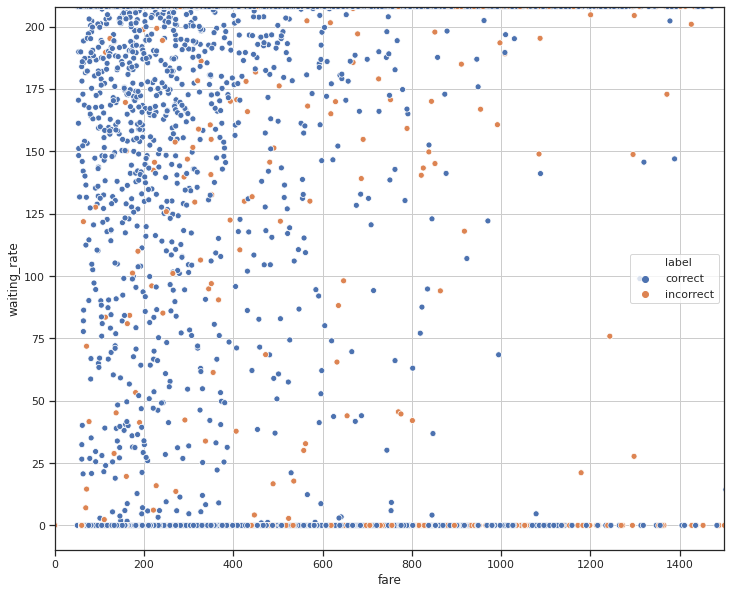

In [ ]:
# train_df[(train_df['label']=='correct')]['waiting_rate'].describe()

plt.figure(figsize = (12,10))
graph = sns.scatterplot(x="fare",y="waiting_rate",data=train_df,hue='label')
graph.set_ylim(-10,208)
graph.set_xlim(0,1500)

graph.grid(True)